In [1]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"swarupmantripragada","key":"e1bcd10d34ac9dfa7bd47a9be406bff1"}'}

In [2]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [3]:
# The Kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Creating directory and changing the current working directory
!mkdir dataset
%cd dataset

/content/dataset


In [5]:
# Searching for dataset
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           2618          6  0.1764706        


In [6]:
# Downloading dataset and coming out of directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

100% 689M/691M [00:05<00:00, 149MB/s]
100% 691M/691M [00:05<00:00, 141MB/s]
/content


In [7]:
# Unzipping downloaded file and removing unusable file
!unzip dataset/dogbreedidfromcomp.zip -d dataset
!rm dataset/dogbreedidfromcomp.zip
!rm dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dataset/train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: dataset/trai

In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras import utils as image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

In [9]:
df = pd.read_csv("dataset/labels.csv")
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
# Getting the shape of the df
df.shape

(10222, 2)

In [11]:
# Visualizeing the breeds
breeds = df["breed"]
counts = breeds.value_counts()
counts

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [12]:
# as we have many number of breeds so as our computers dont have a bigger computional power we would be reducing the breeds as of now to 4
class_names = ['scottish_deerhound','maltese_dog','afghan_hound']
labels = df[df['breed'].isin(class_names)]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,146,0379145880ad3978f9b80f0dc2c03fba,afghan_hound


In [13]:
# Getting the new shape of the df
labels.shape

(359, 3)

In [14]:
# # Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = class_names)

In [15]:
# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
    img = image.load_img('dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.0

100%|██████████| 359/359 [00:03<00:00, 99.34it/s]


In [16]:
# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))


Train Images shape:  (359, 224, 224, 3)  size: 54,039,552
One-hot encoded output shape:  (359, 3)  size: 1,077


In [17]:
# Building the Model
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(class_names), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 16)       0

In [18]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

In [19]:
# Training the model
epochs = 32
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val))

Epoch 1/32
3/3 [==============================] - 45s 10s/step - loss: 4.8831 - accuracy: 0.3217 - val_loss: 4.8590 - val_accuracy: 0.3385
Epoch 2/32
3/3 [==============================] - 35s 9s/step - loss: 4.8459 - accuracy: 0.3682 - val_loss: 4.8277 - val_accuracy: 0.3231
Epoch 3/32
3/3 [==============================] - 37s 9s/step - loss: 4.8145 - accuracy: 0.3682 - val_loss: 4.7996 - val_accuracy: 0.3231
Epoch 4/32
3/3 [==============================] - 35s 9s/step - loss: 4.7827 - accuracy: 0.3682 - val_loss: 4.7709 - val_accuracy: 0.3231
Epoch 5/32
3/3 [==============================] - 35s 9s/step - loss: 4.7540 - accuracy: 0.3682 - val_loss: 4.7413 - val_accuracy: 0.3231
Epoch 6/32
3/3 [==============================] - 35s 9s/step - loss: 4.7263 - accuracy: 0.3682 - val_loss: 4.7138 - val_accuracy: 0.3231
Epoch 7/32
3/3 [==============================] - 38s 9s/step - loss: 4.6974 - accuracy: 0.3682 - val_loss: 4.6873 - val_accuracy: 0.3231
Epoch 8/32
3/3 [=================

In [20]:
# Training the model
epochs = 32
batch_size = 32

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val))

Epoch 1/32
9/9 [==============================] - 37s 4s/step - loss: 3.9978 - accuracy: 0.4302 - val_loss: 4.0313 - val_accuracy: 0.3231
Epoch 2/32
9/9 [==============================] - 35s 4s/step - loss: 3.9114 - accuracy: 0.5736 - val_loss: 3.8862 - val_accuracy: 0.6000
Epoch 3/32
9/9 [==============================] - 35s 4s/step - loss: 3.8363 - accuracy: 0.5581 - val_loss: 3.8002 - val_accuracy: 0.5538
Epoch 4/32
9/9 [==============================] - 35s 4s/step - loss: 3.7075 - accuracy: 0.6163 - val_loss: 3.7005 - val_accuracy: 0.6462
Epoch 5/32
9/9 [==============================] - 35s 4s/step - loss: 3.6198 - accuracy: 0.6318 - val_loss: 3.7950 - val_accuracy: 0.4308
Epoch 6/32
9/9 [==============================] - 37s 4s/step - loss: 3.5264 - accuracy: 0.6589 - val_loss: 3.5495 - val_accuracy: 0.6308
Epoch 7/32
9/9 [==============================] - 35s 4s/step - loss: 3.4478 - accuracy: 0.6783 - val_loss: 3.6954 - val_accuracy: 0.4769
Epoch 8/32
9/9 [==================

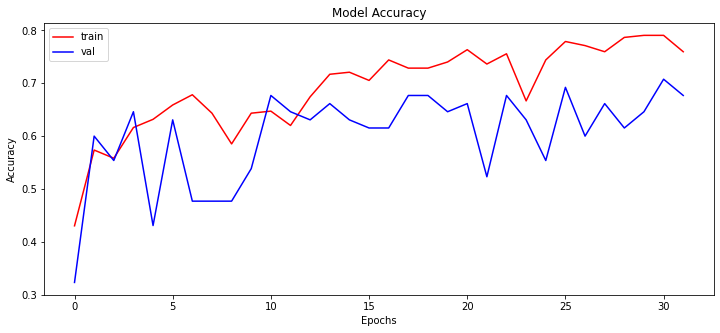

In [21]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [22]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 1s 122ms/step - loss: 2.8511 - accuracy: 0.4722
Accuracy over the test set: 
  47.22 %


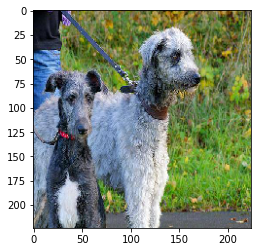

In [23]:
# Plotting image to compare
plt.imshow(X_test[5,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])

In [24]:
model.save("model.h5")

Originally :  scottish_deerhound
Predicted :  scottish_deerhound
